# Import, resize and save image files as .csv

This notebook does the following:

1. Obtains all filename and file paths of files ending with .jpg
2. Extracts label of the image: whether it is pathological or healthy from the file name
3. Saves file names, paths and labels into a .csv

4. Reading and saving images: 
    * Reads images one at a time, 
    * resizes them to be smaller, 
    * converts them to numpy arrays
    * unravels them to be a single vector
    * appends the vectors to a dataframe along with metadata about file and label, and 
    * saves a .csv of this clean dataset 

**Library Imports**

In [17]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from scipy.ndimage import uniform_filter
from plotly import figure_factory as ff
from plotly import express as px

In [2]:
 # get file paths for importing data
file_paths = glob.glob('../data/Images/*.jpg')

get file names and labels: pathological images have file names with `_g_` in them. Images of healthy retinas do not. For instance: 
* `Im001_ACRIMA.jpg` : healthy retina
* `Im696_g_ACRIMA.jpg`: retina with glaucoma


In [3]:
file_name = [Path(directory).name for directory in file_paths]

In [4]:
# get labels
label = [1 if '_g_' in name else 0 for name in file_name]

In [5]:
# create a dataframe and save to .csv for future use
files = pd.DataFrame({'file_path' : file_paths,
                      'file_name': file_name,
                      'label' : label})

# uncomment to save file to csv
# files.to_csv('../data/file_names.csv', index=False) 

**Look at a sample of images from both classes**

In [6]:
# save the filenames of a random set of images
glaucoma_images = files[files['label']==1]['file_name'].sample(5)
healthy_images = files[files['label']==0]['file_name'].sample(5)

In [7]:
# uncomment below to save variable to file
# glaucoma_images.to_csv('../data/glaucoma_images.csv', index=False)
# healthy_images.to_csv('../data/healthy_images.csv', index=False)

In [8]:
glaucoma_images = pd.read_csv('../data/glaucoma_images.csv')
healthy_images = pd.read_csv('../data/healthy_images.csv')

In [9]:
glaucoma_images

file_name
0  Im600_g_ACRIMA.jpg
1  Im659_g_ACRIMA.jpg
2  Im335_g_ACRIMA.jpg
3  Im524_g_ACRIMA.jpg
4  Im564_g_ACRIMA.jpg

Plot images

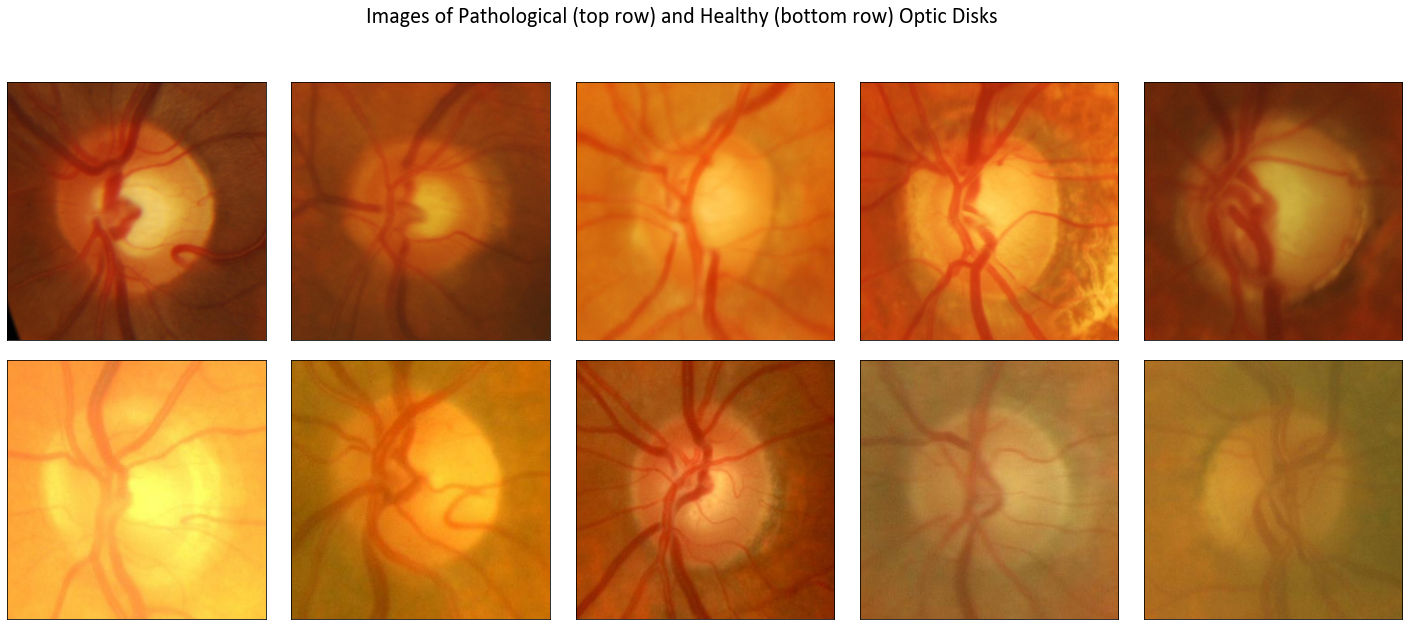

In [10]:
fig, ax = plt.subplots(2, 5, figsize=(25,10))
fig.suptitle('Images of Pathological (top row) and Healthy (bottom row) Optic Disks', 
             size=22)

plt.rcParams.update({'font.sans-serif':'Calibri'})

plt.subplots_adjust(wspace=0.1,
                   hspace=0.05)

for i, f in enumerate(glaucoma_images['file_name']):
    ax[0,i].imshow(Image.open('../data/Images/'+f))
    ax[0,i].set_title(r"$\bf{Glaucoma: }$" + f"{Path(f).name[0:5]}", size=14, color='white')
    ax[0,i].tick_params(
        axis='both',      
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False) 

for i, f in enumerate(healthy_images['file_name']):
    ax[1,i].imshow(Image.open('../data/Images/'+f))
    ax[1,i].set_title(r"$\bf{Healthy: }$" + f"{Path(f).name[0:5]}", size=14, color='white')
    ax[1,i].tick_params(
        axis='both',      
        which='both',
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False) 

# uncomment below to save figure    
# plt.savefig('../figures/sample_images.png', bbox_inches='tight', dpi='figure')

**Examine the distribution of pixel values for sets of sample images from both classes**

In [11]:
sample_size = 100 # set sample size 

glaucoma_images = files[files['label']==1]['file_path'].sample(sample_size)
healthy_images = files[files['label']==0]['file_path'].sample(sample_size)
pixels_g = []
pixels_h = []
for i, f in enumerate(glaucoma_images):
    pixels_g = np.concatenate((pixels_g, np.asarray(Image.open(f).resize((178,178))).ravel())) #get pixel valus as vector

for i, f in enumerate(healthy_images):
    pixels_h = np.concatenate((pixels_h, np.asarray(Image.open(f).resize((178,178))).ravel()))

In [12]:
# convert it to a dataframe
pixels_df = pd.DataFrame({'pixels':np.concatenate((pixels_g, pixels_h)),
                          'label':np.concatenate((['Glaucoma']*len(pixels_g),(['Healthy']*len(pixels_h))))})

pixels_df.head()

pixels     label
0   194.0  Glaucoma
1    41.0  Glaucoma
2     0.0  Glaucoma
3   193.0  Glaucoma
4    40.0  Glaucoma

I'm going to use plotly to generate an interactive figure

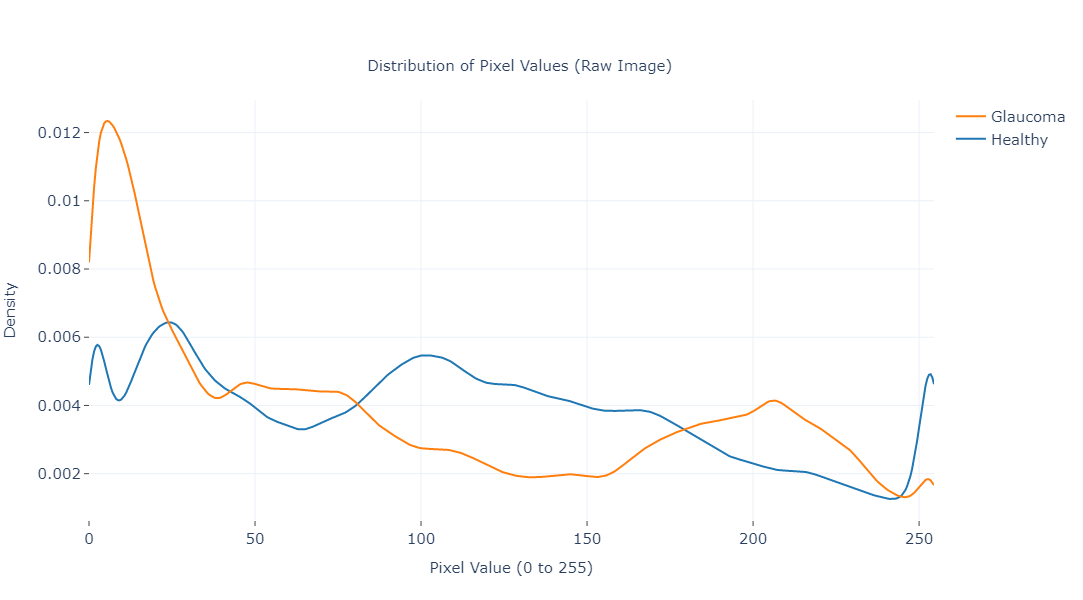

In [13]:
hist_data = [pixels_df[pixels_df['label']=='Healthy']['pixels'], pixels_df[pixels_df['label']=='Glaucoma']['pixels']]
group_labels = ['Healthy', 'Glaucoma']
colors = ['#1f77b4', '#ff7f0e']


fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False, colors=colors)

# Add title
fig.update_layout(width=500,
                  height=600,
                  title_text='Distribution of Pixel Values (Raw Image)',
                  title_y=0.9,
                  title_x=0.48,
                  plot_bgcolor='white',
                  template='plotly_white',
                  legend=dict(font=dict(size=15)),
                  title_font=dict(size=15))

fig.update_xaxes(title='Pixel Value (0 to 255)', title_font_size=15, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Density', title_font_size=15, tickfont_size=15, ticks='outside')

fig.show()

Since I want to run this on streamlit, I can't use the above code. Due to the size of the dataset, it takes several minutes to calculate the histogram and KDE plot. To get around this, I extract the KDE data points that `plotly` generated using `fig.data`, and save that to file. Then I use `plotly` to plot a line plot using this saved file. This generates the same figure, but takes lesser time. 

In [14]:
# extract data from fig to draw line plot

pixels_dist_raw = pd.DataFrame({
    'Healthy':fig.data[0]['y'],
    'Glaucoma': fig.data[1]['y'],
    'Density':fig.data[0]['x']
})


pixels_dist_raw = pd.melt(pixels_dist_raw, id_vars='Density', value_vars=pixels_dist_raw.columns[:])

# uncomment below to save file to directory
# pixels_dist_raw.to_csv('../data/pixels_dist_raw.csv', index=False)

Here's the `plotly express` line plot using the data from distplot. 

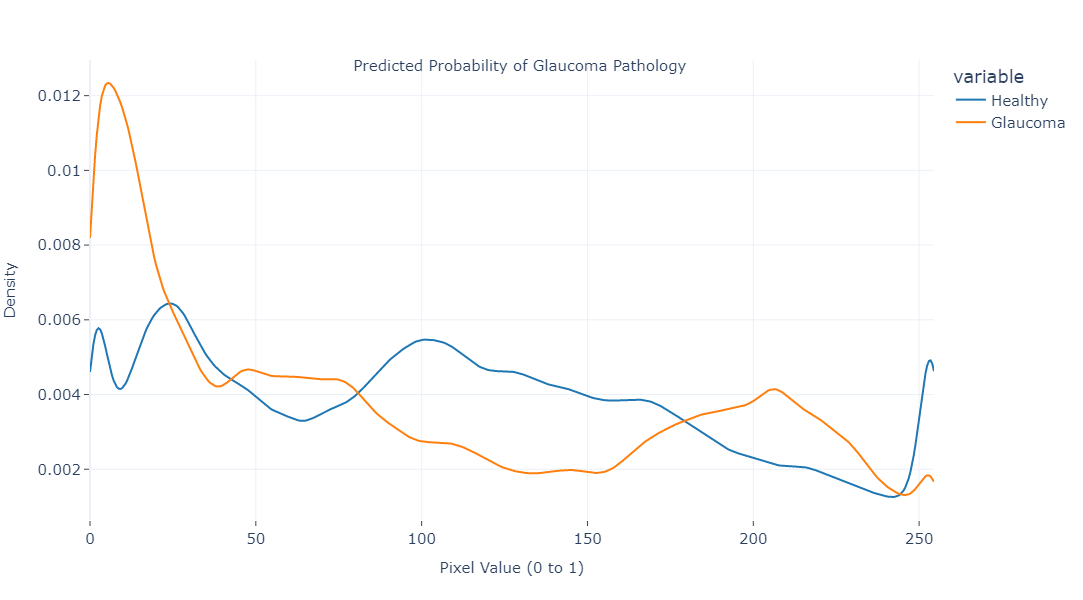

In [36]:
fig = px.line(data_frame=pixels_dist_raw, y='value', x='Density', color='variable', color_discrete_sequence=['#1f77b4', '#ff7f0e'])

# Add title
fig.update_layout(width=500,
                  height=600,
                  title_text='Predicted Probability of Glaucoma Pathology',
                  title_y=0.9,
                  title_x=0.48,
                  plot_bgcolor='white',
                  template='plotly_white',
                  legend=dict(font=dict(size=15)),
                  title_font=dict(size=15))

fig.update_xaxes(title='Pixel Value (0 to 1)', title_font_size=15, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Density', title_font_size=15, tickfont_size=15, ticks='outside')

fig.show()

**Every image does not have the same range of pixel values as shown below:**

In [42]:
rg = []
for f in glaucoma_images:
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,0].ravel()
    rg.append(max(i)-min(i))
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,1].ravel()
    rg.append(max(i)-min(i))
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,2].ravel()
    rg.append(max(i)-min(i))
    
rh = []
for f in healthy_images:
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,0].ravel()
    rh.append(max(i)-min(i))
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,1].ravel()
    rh.append(max(i)-min(i))
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,2].ravel()
    rh.append(max(i)-min(i))

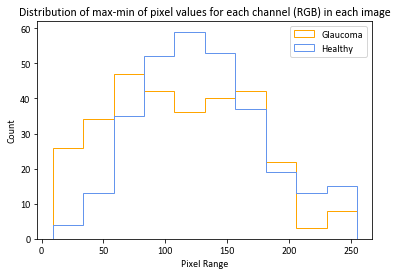

In [55]:
plt.hist(x=rg, label='Glaucoma', color='orange', histtype='step', stacked=True)
plt.hist(x=rh, label='Healthy', color='cornflowerblue', histtype='step', stacked=True)
plt.legend()
plt.title('Distribution of max-min of pixel values for each channel (RGB) in each image')
plt.xlabel('Pixel Range')
plt.ylabel('Count');

**Here I am normalizing every RGB channel of every image in the sample so that the brightest spot in the image has a value of `1` and the darkest spot has the value of `0`**

In [54]:
glaucoma_pixels = []

for f in glaucoma_images:
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,0].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    glaucoma_pixels.append(i)
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,1].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    glaucoma_pixels.append(i)
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,2].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    glaucoma_pixels.append(i)
    
np.shape(glaucoma_pixels)

avg=pd.DataFrame(glaucoma_pixels).mean().values

In [56]:
# uncomment below to save average pixel value to file
# np.save('../data/avg_pixel_val_glaucoma.npy', avg)

In [58]:
healthy_pixels = []

for f in healthy_images:
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,0].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    healthy_pixels.append(i)
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,1].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    healthy_pixels.append(i)
    i = np.asarray(Image.open(f).resize((178, 178)))[:,:,2].ravel()
    div = max(i)
    i = np.array([el/div for el in i])
    healthy_pixels.append(i)
    

avg=pd.DataFrame(healthy_pixels).mean().values

In [144]:
# uncomment below to save to file
# np.save('../data/avg_pixel_val_healthy.npy', avg)

I then repeat the same thing I did earlier to plot the histogram of the normalized pixel values using plotly, and then I save the figure data to file so I can use a line plot to render the same plot on streamlit quickly

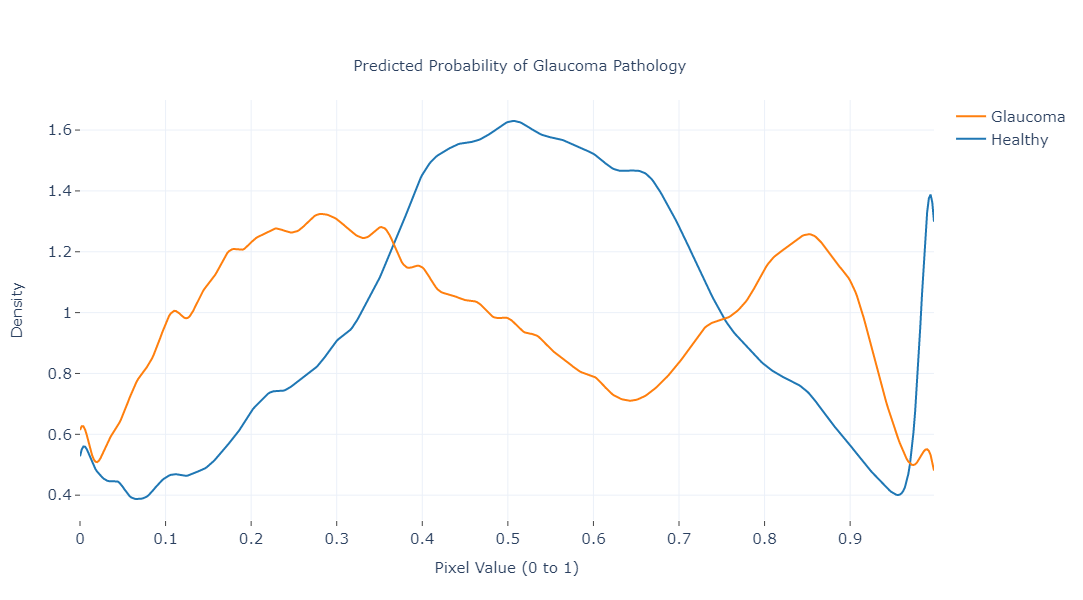

In [59]:
hist_data = [np.ravel(healthy_pixels), np.ravel(glaucoma_pixels)]
group_labels = ['Healthy', 'Glaucoma']
colors = ['#1f77b4', '#ff7f0e']


fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False, colors=colors)

# Add title
fig.update_layout(width=500,
                  height=600,
                  title_text='Predicted Probability of Glaucoma Pathology',
                  title_y=0.9,
                  title_x=0.48,
                  plot_bgcolor='white',
                  template='plotly_white',
                  legend=dict(font=dict(size=15)),
                  title_font=dict(size=15))

fig.update_xaxes(title='Pixel Value (0 to 1)', title_font_size=15, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Density', title_font_size=15, tickfont_size=15, ticks='outside')

fig.show()

In [60]:
fig.data

(Scatter({
     'legendgroup': 'Healthy',
     'marker': {'color': '#1f77b4'},
     'mode': 'lines',
     'name': 'Healthy',
     'showlegend': True,
     'x': [0.0, 0.002, 0.004, ..., 0.994, 0.996, 0.998],
     'xaxis': 'x',
     'y': array([0.52767435, 0.55010109, 0.55998502, ..., 1.38787432, 1.36231265,
                 1.298776  ]),
     'yaxis': 'y'
 }),
 Scatter({
     'legendgroup': 'Glaucoma',
     'marker': {'color': '#ff7f0e'},
     'mode': 'lines',
     'name': 'Glaucoma',
     'showlegend': True,
     'x': [0.0, 0.002, 0.004, ..., 0.994, 0.996, 0.998],
     'xaxis': 'x',
     'y': array([0.61409322, 0.62651597, 0.62616805, ..., 0.53227828, 0.51071818,
                 0.48079913]),
     'yaxis': 'y'
 }))

In [61]:
pixels_dist_normalized = pd.DataFrame({
    'Healthy':fig.data[0]['y'],
    'Glaucoma': fig.data[1]['y'],
    'Density':fig.data[0]['x']
})
pixels_dist_normalized.head()


Healthy  Glaucoma  Density
0  0.527674  0.614093    0.000
1  0.550101  0.626516    0.002
2  0.559985  0.626168    0.004
3  0.559227  0.615208    0.006
4  0.550718  0.596781    0.008

In [62]:
pixels_dist_normalized=pd.melt(pixels_dist_normalized, id_vars='Density', value_vars=pixels_dist_normalized.columns[:])

In [63]:
pixels_dist_normalized.head(1)

Density variable     value
0      0.0  Healthy  0.527674

In [64]:
# uncomment beow to save to file
# pixels_dist_normalized.to_csv('../data/pixels_distribution_normalized.csv', index=False)

In [65]:
pixels_dist_normalized = pd.read_csv('../data/pixels_distribution_normalized.csv')
pixels_dist_normalized.head(2)

Density variable     value
0    0.000  Healthy  0.733703
1    0.002  Healthy  0.757429

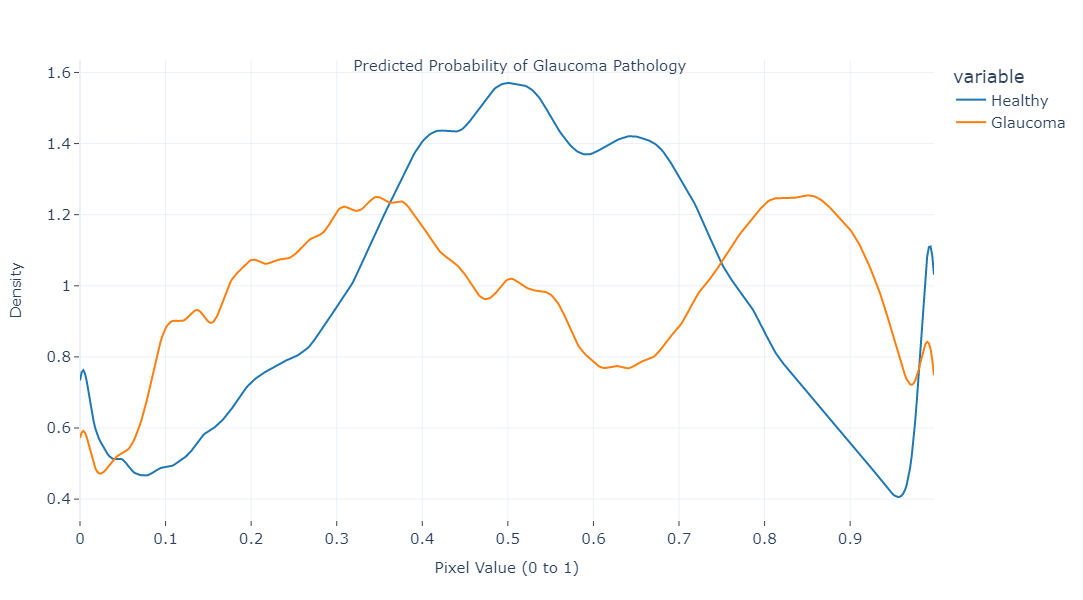

In [66]:
fig = px.line(data_frame=pixels_dist_normalized, y='value', x='Density', color='variable', color_discrete_sequence=['#1f77b4', '#ff7f0e'])

# Add title
fig.update_layout(width=500,
                  height=600,
                  title_text='Predicted Probability of Glaucoma Pathology',
                  title_y=0.9,
                  title_x=0.48,
                  plot_bgcolor='white',
                  template='plotly_white',
                  legend=dict(font=dict(size=15)),
                  title_font=dict(size=15))

fig.update_xaxes(title='Pixel Value (0 to 1)', title_font_size=15, tickfont_size=15, ticks='outside')
fig.update_yaxes(title='Density', title_font_size=15, tickfont_size=15, ticks='outside')

fig.show()

**Next I look at how pixel values are distributed spatially across the images, to check if that looks visually different between the two classes**

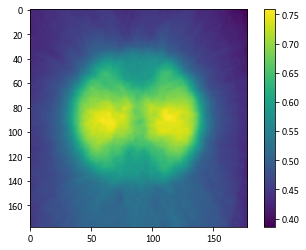

In [68]:
plt.imshow(avg.reshape((178,178)))
plt.colorbar();

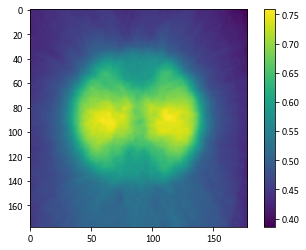

In [69]:
plt.imshow(avg.reshape((178,178)))
plt.colorbar();

## Data cleaning and save to file for training model

**Import images and convert to numpy array**

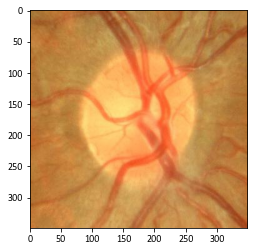

In [71]:
# check if numpy array can still be used as an image
x = np.asarray(Image.open(files['file_path'][0]))
plt.imshow(x);

In [72]:
# Check how to `.ravel()` and `.reshape()`
# unravel image tobe a vector
shape = x.shape
y = x.ravel()

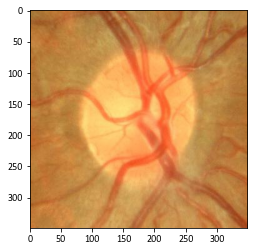

In [73]:
# reshape it back to the shape it was a plot it
plt.imshow(y.reshape(shape));

**Create dataframe with image array in it**

In [74]:
# Create a dataframe with fields: file path, file name, label, image and image shape

data_df = files.copy()
shape = []                                    # create an empty list to put shape of every image 
image = []                                    # crate empty list to store image

In [75]:
data_df.head()

file_path         file_name  label
0  ../data/Images\Im001_ACRIMA.jpg  Im001_ACRIMA.jpg      0
1  ../data/Images\Im002_ACRIMA.jpg  Im002_ACRIMA.jpg      0
2  ../data/Images\Im003_ACRIMA.jpg  Im003_ACRIMA.jpg      0
3  ../data/Images\Im004_ACRIMA.jpg  Im004_ACRIMA.jpg      0
4  ../data/Images\Im005_ACRIMA.jpg  Im005_ACRIMA.jpg      0

**All my images are of different sizes, so I will resize them to be the same size as the smallest image** 

In [76]:
# find the size of smallest image
im_size = []
for f in data_df['file_path']:
    im = Image.open(f)
    im_size.append(im.size)
min_size = min(im_size)

In [77]:
h = [h for h,w in im_size]
w = [w for h,w in im_size]

In [78]:
sizes_df = pd.DataFrame({'h':h, 'w':w})
sizes_df['label'] = files['label']
sizes_df['label'].replace({1:'Glaucoma', 0:'Healthy'}, inplace=True)
sizes_df['ratio'] = sizes_df['h']/sizes_df['w']
sizes_df.head()

h    w    label  ratio
0  349  349  Healthy    1.0
1  277  277  Healthy    1.0
2  409  409  Healthy    1.0
3  406  406  Healthy    1.0
4  316  316  Healthy    1.0

In [79]:
# uncomment below to save to file
# sizes_df.to_csv('../data/image_sizes.csv', index=False)

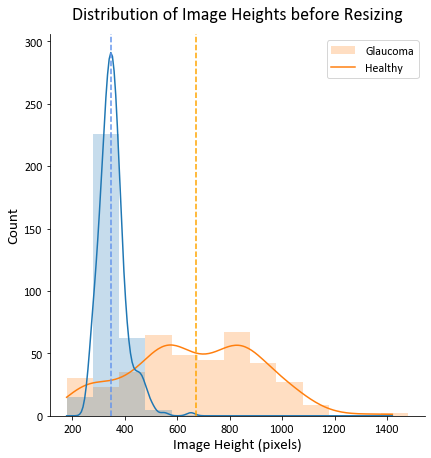

In [80]:
# establish palette so Glaucoma is always orange
palette = {"Healthy":"tab:blue",
           "Glaucoma":"tab:orange"}

# set up font for plot
plt.rcParams.update({'font.sans-serif':'Calibri'})

# plot
sns.displot(data=sizes_df, 
            x='h', 
            hue='label',    # assign colors based on label
            kind='hist',    # plot histogram
            binwidth=100, 
            kde=True,       # also plot kde
            element='step', # plot histogram as step
            height=6, 
            legend=False,   # don't plot legend
            palette=palette,# use palette to assign colors
            edgecolor=None) # don't draw dark line around histogram

# add median lines
plt.axvline(sizes_df.groupby('label').median().loc['Glaucoma'].values[0], 
            ymax=240, linestyle='dashed', color='orange')

plt.axvline(sizes_df.groupby('label').median().loc['Healthy'].values[0], 
            ymax=240, linestyle='dashed', color='cornflowerblue')

# labels and title
plt.legend(['Glaucoma', 'Healthy'], fontsize=12)
plt.xlabel('Image Height (pixels)', size=15)
plt.ylabel('Count', size=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Distribution of Image Heights before Resizing', size=18, y=1, pad=15);

# uncomment below to save figure    
# plt.savefig('../figures/size_distribution.png', bbox_inches='tight', dpi=300)

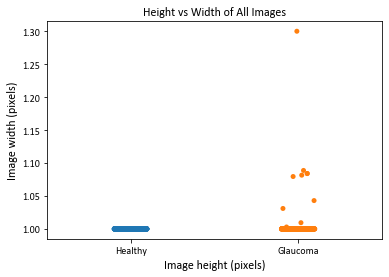

In [81]:
sns.stripplot(data=sizes_df, x='label', y='ratio')
plt.xlabel('Image height (pixels)', size=12)
plt.ylabel('Image width (pixels)', size=12)
plt.title('Height vs Width of All Images');

# uncomment below to save figure    
# plt.savefig('../figures/sizes_ratios.png', bbox_inches='tight', dpi='figure')

In [21]:
min_size

(178, 178)

Pixel values for original image range between 10 and 255
Pixel values for resized image range between 12 and 255


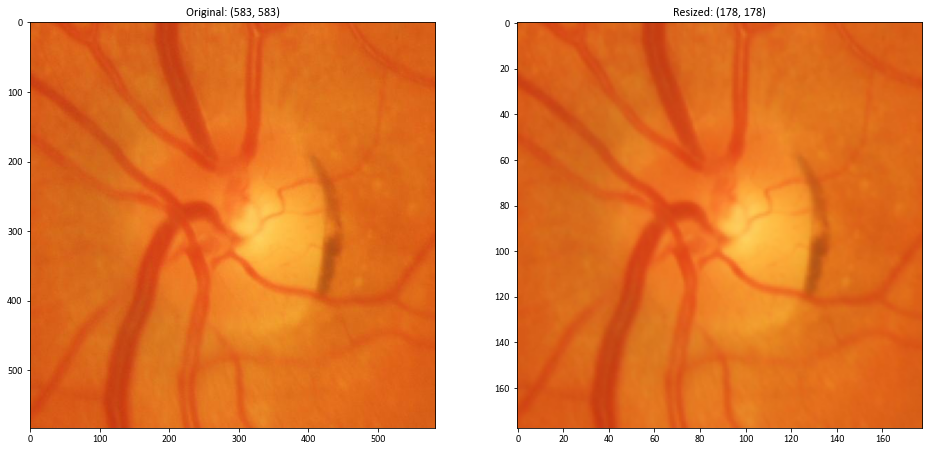

In [82]:
# double check to make sure that the resized image is not visibly reduced in quality
f = files['file_path'].sample(1).values[0]
im = Image.open(f)
print(f"Pixel values for original image range between {np.asarray(im).min()} and {np.asarray(im).max()}")
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(im)
ax[0].set_title(f'Original: {im.size}')

im = im.resize((178, 178))
print(f"Pixel values for resized image range between {np.asarray(im).min()} and {np.asarray(im).max()}")
ax[1].imshow(im)
ax[1].set_title(f'Resized: {im.size}');

    

**Create dataframe**

In [83]:
# for every image in the list:
for f in data_df['file_path']:
    im = Image.open(f)       # open image
    im = im.resize(min_size) # resize to size of smallest image
    im = np.asarray(im)      # convert to array
    shape.append(im.shape)   # save shape of array
    im = im.ravel()          # convert 3D array to a vector
    image.append(im)         # append to list

In [84]:
data_df['shape'] = shape
data_df.head()

file_path         file_name  label          shape
0  ../data/Images\Im001_ACRIMA.jpg  Im001_ACRIMA.jpg      0  (178, 178, 3)
1  ../data/Images\Im002_ACRIMA.jpg  Im002_ACRIMA.jpg      0  (178, 178, 3)
2  ../data/Images\Im003_ACRIMA.jpg  Im003_ACRIMA.jpg      0  (178, 178, 3)
3  ../data/Images\Im004_ACRIMA.jpg  Im004_ACRIMA.jpg      0  (178, 178, 3)
4  ../data/Images\Im005_ACRIMA.jpg  Im005_ACRIMA.jpg      0  (178, 178, 3)

In [85]:
# convert the list image to an numpy array 
image = np.array(image)

In [86]:
# convert the list of image arrays into a dataframe. This will place each pixel value in a separate column
# then concatenate it to the dataframe with the other details about the image
data_df = pd.concat([data_df, pd.DataFrame(image)], axis=1)
data_df.head()

file_path         file_name  label          shape  \
0  ../data/Images\Im001_ACRIMA.jpg  Im001_ACRIMA.jpg      0  (178, 178, 3)   
1  ../data/Images\Im002_ACRIMA.jpg  Im002_ACRIMA.jpg      0  (178, 178, 3)   
2  ../data/Images\Im003_ACRIMA.jpg  Im003_ACRIMA.jpg      0  (178, 178, 3)   
3  ../data/Images\Im004_ACRIMA.jpg  Im004_ACRIMA.jpg      0  (178, 178, 3)   
4  ../data/Images\Im005_ACRIMA.jpg  Im005_ACRIMA.jpg      0  (178, 178, 3)   

     0    1   2    3    4   5  ...  95042  95043  95044  95045  95046  95047  \
0  162  115  50  163  115  51  ...     34    167     72     34    168     71   
1  144  108  56  145  109  57  ...     25    145     75     26    145     75   
2  254  155  26  254  156  27  ...     51    220    146     51    220    146   
3  162   76   1  162   79   1  ...      1    159     52      0    159     54   
4  179   87   2  179   87   2  ...     11    177    108     13    178    109   

   95048  95049  95050  95051  
0     33    163     67     28  
1     26    146     76     27  
2     52    219    146     52  
3      0    161     55      0  
4     14    178    109     14  

[5 rows x 95056 columns]

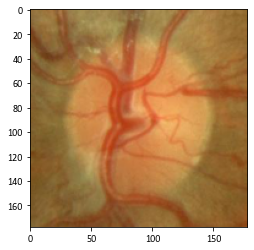

In [87]:
# test to make sure data is preserved
# to break that down: 
    # data_df.drop(columns=['file_path', 'file_name', 'label', 'shape']) removes all non-pixel columns
    # .iloc[1,:].values accesses the first row of pixels, i.e, the first image
    # .reshape((178, 178, 3)) reshapes it back to an image from a vector

plt.imshow(data_df.drop(columns=['file_path', 'file_name', 'label', 'shape']).iloc[1,:].values.reshape((178, 178, 3)));


In [88]:
# uncomment to save dataframe to disk as .csv
# data_df.to_csv('../data/clean_data.csv', index=False)